## 演習問題１
転移学習やスクラッチからの学習などを用いて、自分で選んだ面白い画像データの分類を学習させてみましょう。

データのダウンロードから最後モデルを完成させるところまで、コーディングを含めて練習するのが目的なので、webや書籍のコードをただコピーしてきて走らせるのはダメ・論外です。

参考程度に、使えそうなデータに以下のようなものがあります：

- 車の分類
https://ai.stanford.edu/%7Ejkrause/cars/car_dataset.html


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import scipy.io
import os
import shutil
import torch
from PIL import Image
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D

In [2]:
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/drive


device(type='cuda')

In [3]:
home_path = '/content/drive/My Drive/ml_datasets/cars'
home_path_train = '/content/drive/My Drive/ml_datasets/cars_train'
home_path_test = '/content/drive/My Drive/ml_datasets/cars_test'
home_path_BK = '/content/drive/My Drive/ml_datasets/cars_BK'

In [4]:
%cd /content/drive/My Drive/ml_datasets/cars

/content/drive/My Drive/ml_datasets/cars


## 前処理

### データロード
https://ai.stanford.edu/%7Ejkrause/cars/car_dataset.html

The Cars dataset contains 16,185 images of 196 classes of cars.

The data is split into 8,144 training images and 8,041 testing images

「car_ims.tar」と「cars_annos.mat」をダウンロードする

In [5]:
#!tar -xvf '/content/drive/My Drive/ml_datasets/cars/car_ims.tar' -C '/content/drive/My Drive/ml_datasets/cars'

In [10]:
files = os.listdir(home_path_BK+'/car_ims')
print(len(files))

16185


In [11]:
# 「cars_annos.mat」をロード
data = scipy.io.loadmat(home_path_BK + '/cars_annos.mat')

# 注釈
annotations = data['annotations']
# 属性名称
classNames = data['class_names']

In [12]:
# サイズを表示
print(annotations.shape, classNames.shape)

(1, 16185) (1, 196)


### データ表示

In [13]:
# 車の画像ファイル
print(annotations[0, 0][0])

# 車の名称
print(classNames[0, annotations[0, 0][5][0][0]-1])

['car_ims/000001.jpg']
['AM General Hummer SUV 2000']


In [14]:
annotations[0, 12110][6][0][0]

1

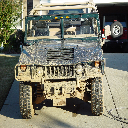

In [15]:
# 車の画像をロード
img_path = home_path_BK + '/car_ims/000001.jpg'
img = image.load_img(img_path, target_size=(128, 128))

# 車の画像を表示
img

### 分類フォルダの作成

In [ ]:
# 各imageは、所属するclassに格納する
for i in range(annotations.shape[1]):

  # 車の画像ファイルを取得
  annot_path = str(annotations[0, i][0])[2:-2]
  image_path = os.path.join(home_path_BK, annot_path)

  # 車の名称indexを取得
  label = annotations[0, i][5][0][0]
  # 車の名称を取得
  class_name = str(classNames[0, label-1][0]).replace(" ", "_").replace("/", "")
  class_path = os.path.join(home_path, class_name)

  # test:1,train:0
  # テスト用フォルダファイル作成
  if annotations[0, i][6][0][0] == 1:
    class_path_test = os.path.join(home_path_test, class_name)

    if not os.path.exists(class_path_test):
      os.makedirs(class_path_test)

    if not os.path.exists(class_path_test+annot_path[7:]):
      #print(home_path_test+annot_path[7:])
      shutil.copy(image_path, class_path_test)

  # 訓練用フォルダファイル作成
  elif annotations[0, i][6][0][0] == 0:
    class_path_train = os.path.join(home_path_train, class_name)

    if not os.path.exists(class_path_train):
      os.makedirs(class_path_train)

    if not os.path.exists(class_path_train+annot_path[7:]):
      #print(class_path_train+annot_path[7:])
      shutil.copy(image_path, class_path_train)

  else:
    print(class_path+annot_path[7:])


### 画像チェック
分類操作で、画像は壊される可能性があります。壊れた画像は訓練された時↓エラーが出ました。事前に全部画像をチェックする

PIL.UnidentifiedImageError: cannot identify image file

In [ ]:
i = 0
def is_read_successfully(file):
    try:
        imgFile = Image.open(file)
        return True
    except Exception:
        return False

# 実行時間がかかるので、１回目した後、Falseを設定する
flag = False
if flag:
  for parent, dirs, files in os.walk(home_path_train):#(root,dirs,files)
      for file in files:
          if not is_read_successfully(os.path.join(parent, file)):
              print(os.path.join(parent, file))
              #os.remove(os.path.join(parent, file))
              i = i + 1
print(i)

## 転移学習

### モデルの構築

In [17]:
# 畳み込み層部分だけのVGGをロードする
model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# パラメータを学習しないようにfreezeする
model_vgg.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [18]:
model = Sequential([
        model_vgg,
        GlobalAveragePooling2D(),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dense(196, activation='softmax')
    ], name = "model_vgg")

model.summary()

model.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

Model: "model_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0 

### データジェネレータの作成

In [19]:
BATCH_SIZE = 128

# インスタンスを作成。前処理やランダムなデータ水増しの変形範囲を指定
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=preprocess_input, #今回は特殊な前処理を使っているので、VGGの前処理関数を指定
    width_shift_range=0.1, #水平方向への移動範囲
    height_shift_range=0.1, #垂直方向への移動範囲
    rotation_range = 10, #回転角度の範囲
    shear_range = 0.2, #シアー(傾斜角)の範囲
    zoom_range=0.2, #拡大率の範囲
    horizontal_flip=True,
    validation_split=0.2
    )

# ImageDataGeneratorのインスタンスにflow_from_dierctory()で画像を渡す

train_generator = train_datagen.flow_from_directory(
    home_path_train, #画像フォルダのあるディレクトリ
    target_size=(128, 128), #読み込んだ画像のサイズ
    batch_size=BATCH_SIZE, #ミニバッチサイズ
    class_mode='categorical', #多クラス分類用のラベルyも生成
    subset='training',
    shuffle=True
    )

val_generator = train_datagen.flow_from_directory(
    home_path_train, #画像フォルダのあるディレクトリ
    target_size=(128, 128), #読み込んだ画像のサイズ
    batch_size=BATCH_SIZE, #ミニバッチサイズ
    class_mode='categorical', #多クラス分類用のラベルyも生成
    subset='validation',
    shuffle=True
    )

Found 36 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


### 訓練

In [20]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    validation_data=val_generator,
                    epochs=16)

Epoch 1/16


ValueError: ignored

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))

ax1.plot(train_loss, label='train_loss')
ax1.plot(val_loss, label='val_loss')
ax2.plot(train_acc, label='train_acc')
ax2.plot(val_acc, label='val_acc')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
ax1.legend()
ax2.legend()
fig.tight_layout()
plt.show()